# Background

In this notebook we want to test the intermittent-correlations model.

In [2]:
import os, sys
%pylab inline
plt.style.use('default')


Populating the interactive namespace from numpy and matplotlib


In [3]:
from importlib import reload
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Model data

First we'll test the model on some data generated from the model itself.

In [4]:
# Generate data from the model
def gen_data(M, λ, μ, σ, γ, do_plot = False):
    # Generate the data
    y = zeros(M)
    z = rand(M) < γ
    i0= ~z
    n0= np.sum(~z)
    i1= z
    n1= np.sum(z)
    pp= λ/(λ + μ)
    ip= rand(M)<pp
    # Set y at ip to be sampled from an exponential with mean λ
    y[ip] = np.random.exponential(λ, sum(ip))
    # Set y at ~ip to be sampled from an exponential with mean μ
    y[~ip]= -np.random.exponential(μ, sum(~ip))       
    y[~z] = randn(n0)*σ
    
    labs = 0*z
    labs[z & (y>=0)] = 1
    labs[z & (y<0)]  = -1
    return y, labs

def plot_data(λ, μ, σ, γ, y, labs):
    figure(figsize=(12,4))
    plot(y,color="gray")
    plot(where(labs>0)[0],  y[labs>0],  'b.', label="pos")
    plot(where(labs<0)[0],  y[labs<0],  'r.', label="neg")
    plot(where(labs==0)[0], y[labs==0], 'k.', label="noise")
    legend()
    title(f"λ={λ:1.2e}, μ={μ:1.2e}, σ={σ:1.2e}, γ={γ:1.2e}")

def plot_confusion_matrix(true_labs, pred_labs):
    cm = confusion_matrix(true_labs, pred_labs, normalize="true")
    ConfusionMatrixDisplay(cm, display_labels = ["-1","0","1"]).plot()    

from scipy.stats import norm
def cdf(λ, μ, σ, γ, y):
    # Compute the CDF
    R = fpt.alaplace_cdf(λ, μ, y)
    H = norm.cdf(y, scale = σ)
    return γ*R + (1-γ)*H

In [5]:
def run_em(y, β = 1, γ_init = 0.1, max_iter = 10, tol = 1e-6):
    # Initialize
    M     = len(y)
    γ_old = γ_init
    λ_old, μ_old, σ2_old = np.inf, np.inf, np.inf

    # Take the top M γ active values as those that active
    ind_z = argsort(-abs(y))[:int(M * γ_old)]    
    z = 0*y
    z[ind_z] = 1
    z = z.astype(bool)
    for i in range(max_iter):
        # E-step
        if i > 0:
            lrho = 0 * y
            lrho[y>=0] = log(2/(λ + μ))-abs(y[y>=0])/λ
            lrho[y<0]  = log(2/(λ + μ))-abs(y[y< 0])/μ
            leta       = -y**2/2/σ2 - log(sqrt(2*pi*σ2))
            z   = (lrho - leta) > log((1-min(γ,1-1e-8))/γ)
        # M-step
        γ = mean(z)
        n0= sum(~z)        
        if n0>0:
            y0 = y[~z]
            σ2 = n0/(2*β) * (-1 + sqrt(1 + 4 * β * mean(y0**2)/n0))
        else:
            σ2 = var(y)*1e-3 # Don't make it exactly 0

        ip = z & (y>=0)
        i_n= z & (y<0)    
        ypm= mean(y[ip]) if sum(ip) else 0
        ynm= mean(abs(y[i_n])) if sum(i_n) else 0
        λ = ypm + sqrt(ypm * ynm)
        μ = max(ynm + sqrt(ypm * ynm),1e-6)

        # Print the values at the current iteration, including the iteration number
        print(f"Iter {i:>4d}: λ={λ:.3e}, μ={μ:.3e}, σ={sqrt(σ2):.3e}, γ={γ:.3e}")        
        # Check convergence
        if abs(λ - λ_old) < tol and abs(μ - μ_old) < tol and abs(σ - σ_old) < tol and abs(γ - γ_old) < tol:
            print("Converged.")
            break
        λ_old = λ
        μ_old = μ
        σ_old = σ
        γ_old = γ

    labs = 0*z
    labs[z & (y>=0)] = 1
    labs[z & (y<0)]  = -1
    return λ, μ, sqrt(σ2), γ, labs

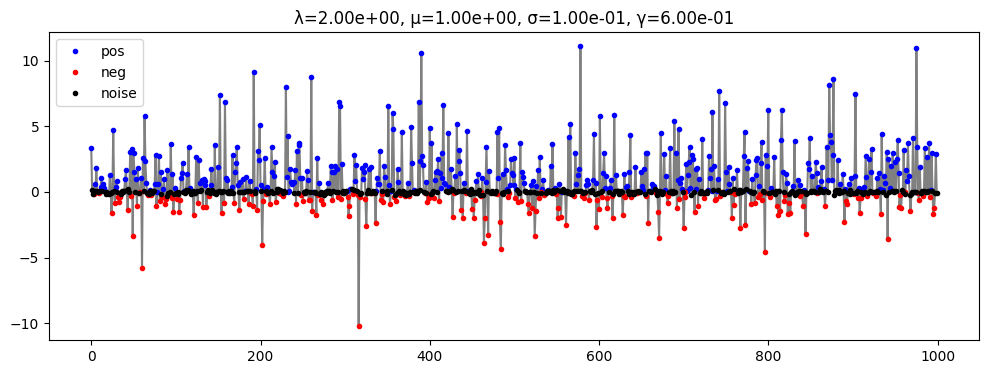

In [6]:
random.seed(0)
M = 1000
λ = 2.
μ = 1.
σ = 0.1
γ = 0.6
y,labs = gen_data(M, λ, μ, σ, γ)
plot_data(λ, μ, σ, γ, y, labs)


Iter    0: λ=4.040e+00, μ=3.001e+00, σ=1.131e-01, γ=5.000e-01
Iter    1: λ=3.967e+00, μ=2.910e+00, σ=1.051e-01, γ=5.130e-01
Iter    2: λ=3.911e+00, μ=2.878e+00, σ=1.011e-01, γ=5.210e-01
Iter    3: λ=3.900e+00, μ=2.850e+00, σ=9.970e-02, γ=5.240e-01
Iter    4: λ=3.892e+00, μ=2.831e+00, σ=9.879e-02, γ=5.260e-01
Iter    5: λ=3.888e+00, μ=2.822e+00, σ=9.835e-02, γ=5.270e-01
Iter    6: λ=3.888e+00, μ=2.822e+00, σ=9.835e-02, γ=5.270e-01
Converged.
(3.8882820815832426, 2.821690960104309, 0.09834796674122967, 0.527)


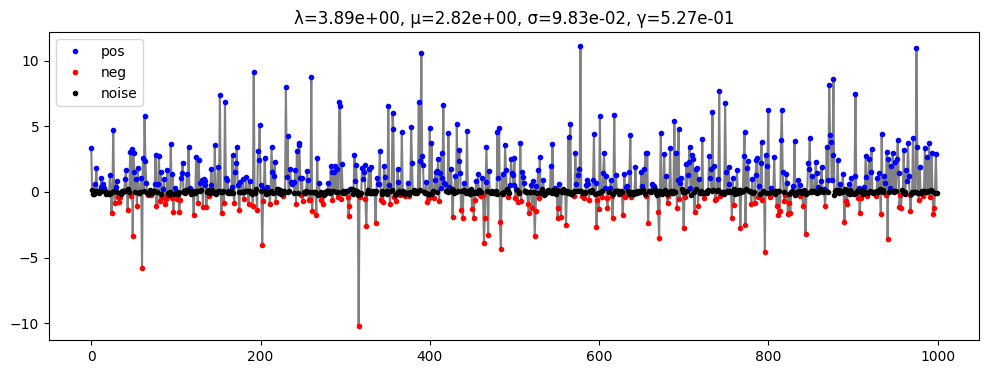

In [7]:
ret = run_em(y, β = 1, γ_init = 0.5, max_iter = 50, tol = 1e-6)
print(ret[:4])
plot_data(*ret[:4], y, *ret[4:])

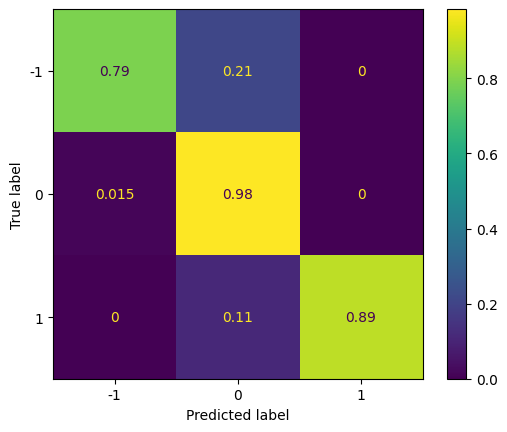

In [8]:
plot_confusion_matrix(labs, ret[4])

# Let's try on the real data

In [9]:
# Load the data
os.environ["FISHER_PLUMES"] = os.path.join(os.environ["GIT"],"fisher-plumes")
os.chdir(os.environ["FISHER_PLUMES"])
import units; reload(units); UNITS = units.UNITS;

In [10]:
import boulder;   reload(boulder)
import crick;     reload(crick)
import surrogate; reload(surrogate)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils); from utils import dict_update, dict_update_from_field
import proc; reload(proc);
FisherPlumes = fp.FisherPlumes
crick.logger.setLevel(logging.DEBUG)
fp.logger.setLevel(logging.INFO)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_w1                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w2                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w3                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w4                                     : y0 - y9 (16 datasets)


INFO:crick:n12T                                            : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12Tslow                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12dishT                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n16T                                            : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow                                        : Y0.440 - Y0.560 (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:crimgrid_w1                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w2                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w3                                     : y0 - y9 (16 datasets)


INFO:crick:crimgrid_w4                                     : y0 - y9 (16 datasets)


INFO:crick:n12T                                            : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12Tslow                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n12dishT                                        : Y0.450 - Y0.550 (11 datasets)


INFO:crick:n16T                                            : Y0.440 - Y0.560 (16 datasets)


INFO:crick:n16Tslow                                        : Y0.440 - Y0.560 (16 datasets)


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'high', 'spike_and_slab', 'blue', 'red', 'all_equal']


In [11]:
window_length = 1 * UNITS.second
windows       = ['boxcar', 'hann', ('kaiser',9), ('kaiser', 16)]
window_shape  = windows[1]
fit_k         = False
fit_b         = True


In [12]:
to_use = {"16Ts":{"sim_name":"n16Tslow"},
          "bw":  {"sim_name":"boulder16"},
          "s=w": {"sim_name":"surr_all_equal", "surrogate_k": 0},
          "s=p": {"sim_name":"surr_all_equal", "surrogate_k": 4},
          "shw": {"sim_name":"surr_high",      "surrogate_k": 0},          
          "shp": {"sim_name":"surr_high",      "surrogate_k": 4},
          "s=w_q0":{"sim_name":"surr_quad",      "surrogate_k": 0, "phi":0},
          "s=w_q1":{"sim_name":"surr_quad",      "surrogate_k": 0, "phi":pi/3},
}


In [13]:
safe_load = lambda d: d[0] if d is not None else d
[f.logger.setLevel(logging.WARN) for f in [crick, boulder,fp]];
loaded = {k:safe_load(proc.load_data(init_filter = v,
                                       compute_filter = {
                                           "window_shape":window_shape,
                                           "window_length":window_length,
                                           "fit_k":fit_k,
                                           "fit_b":fit_b,
                                       }))
          for k,v in to_use.items()}

data =  {k:FisherPlumes(d) for k,d in loaded.items() if d is not None}

for k, l in loaded.items():
    if l is None:
        print(f"WARNING: No data for {k=}")

[f.logger.setLevel(logging.INFO) for f in [crick, boulder,fp]];


                    proc 2023/08/31 17:25:25     INFO: Loading init_filter={'sim_name': 'n16Tslow'} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/n16Ts.1/78281891d4d0a86d.p


                    proc 2023/08/31 17:25:30     INFO: Returning 1 results.


                    proc 2023/08/31 17:25:30     INFO: Loading init_filter={'sim_name': 'boulder16'} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/bw.1/a870f77347a4942f.p


                    proc 2023/08/31 17:25:33     INFO: Returning 1 results.


                    proc 2023/08/31 17:25:33     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 0} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=w.1/d939203ae60ec26a.p


                    proc 2023/08/31 17:25:34     INFO: Returning 1 results.


                    proc 2023/08/31 17:25:34     INFO: Loading init_filter={'sim_name': 'surr_all_equal', 'surrogate_k': 4} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=p.1/ea1b3a6e626f84a2.p


                    proc 2023/08/31 17:25:35     INFO: Returning 1 results.


                    proc 2023/08/31 17:25:35     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 0} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/shw.1/c608e21b188eccdc.p


                    proc 2023/08/31 17:25:37     INFO: Returning 1 results.


                    proc 2023/08/31 17:25:37     INFO: Loading init_filter={'sim_name': 'surr_high', 'surrogate_k': 4} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/shp.1/9aa0c12903638012.p


                    proc 2023/08/31 17:25:38     INFO: Returning 1 results.


                    proc 2023/08/31 17:25:38     INFO: Loading init_filter={'sim_name': 'surr_quad', 'surrogate_k': 0, 'phi': 0} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=w_q.1/590d29b026eb2834.p


                    proc 2023/08/31 17:25:39     INFO: Returning 1 results.


                    proc 2023/08/31 17:25:39     INFO: Loading init_filter={'sim_name': 'surr_quad', 'surrogate_k': 0, 'phi': 1.0471975511965976} compute_filter={'window_shape': 'hann', 'window_length': <Quantity(1, 'second')>, 'fit_k': False, 'fit_b': True} from proc/s=w_q.2/7213b58bc65c326d.p


                    proc 2023/08/31 17:25:40     INFO: Returning 1 results.


INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coor

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], '

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coor

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'co

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'all_equal', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_all_equal_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_all_equal_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_all_equal_pitch')>, 'y': <Quantity([[0]], 'surr_all_equal_pitch')>}, 'x': <Quantity([10], 'surr_all_equal_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_all_equal_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_all_equal_pitch')>, <Quantity(10, 'surr_all_equal_pitch')>], 'y_lim': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_all_equal_pitch')>, <Quantity(0, 'surr_all_equal_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'all_equal', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'c

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-59.10548154],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-59.10548154],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-19.89229135],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-12.44132889],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 18.49143025],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-63.2686171 ],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-60.09607302],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-56.14996259],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-25.55298284],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-32.55458394],
       [ 

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-11.57091867],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-12.9775294 ],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-41.73591707],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-57.06706625],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-19.65668695],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-21.26115061],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 14.80550149],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-7.09763417],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-7.09763417],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-7.9967684 ],
      

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-14.36303866],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-12.56674671],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-16.27835016],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-16.34731828],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-14.11810432],
     

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -7.15038746],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -9.94393516],
       [-

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-5.9693652 ],
       [

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-0.80587148],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-1.09364524],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-2.18398555],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-4.95836736],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 0.4910835 ],
       

INFO:surrogate:
{'tol': 0, 'name': 'high', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_high_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_high_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_high_pitch')>, 'y': <Quantity([[0]], 'surr_high_pitch')>}, 'x': <Quantity([10], 'surr_high_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_high_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_high_pitch')>, <Quantity(10, 'surr_high_pitch')>], 'y_lim': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_high_pitch')>, <Quantity(0, 'surr_high_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'high', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'surrogate_k': 4}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-5.241228  ],
       

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-59.105481

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-59.105481

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -5.849007

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -4.574717

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 33.909967

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-75.398814

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-44.311011

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-41.766802

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[19.70954707]

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ -8.25426173],

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[   7.4133005

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[  8.7539695

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-53.6985321

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-77.0756848

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-26.8604322

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[-23.2495403

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 0, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array([[ 14.9550891

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S0'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S1'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S2'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S3'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S4'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S5'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([     0. -11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S6'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': a

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. -3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S7'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': arr

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([   0. 3750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S8'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': array

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 11250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S9'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': arr

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 18750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S10'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 26250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S11'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 33750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S12'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 41250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S13'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 48750.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S14'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

INFO:surrogate:
{'tol': 0, 'name': 'quad', 'class_name': 'SurrogateSimulationData', 'units': <Unit('meter')>, 'pitch_units': <Quantity(1, 'surr_quad_pitch')>, 'pitch_sym': 'ϕ', 'pitch': <Quantity(1, 'surr_quad_pitch')>, 'probe_grid': {'x': <Quantity([[10]], 'surr_quad_pitch')>, 'y': <Quantity([[0]], 'surr_quad_pitch')>}, 'x': <Quantity([10], 'surr_quad_pitch')>, 'nx': 1, 'y': <Quantity([0], 'surr_quad_pitch')>, 'ny': 1, 'nz': 1, 'x_lim': [<Quantity(10, 'surr_quad_pitch')>, <Quantity(10, 'surr_quad_pitch')>], 'y_lim': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'source': <Quantity([    0. 56250.], 'micrometer')>, 'dimensions': [<Quantity(0, 'surr_quad_pitch')>, <Quantity(0, 'surr_quad_pitch')>], 'fields': ['S15'], 'fs': <Quantity(50, 'hertz')>, 'surr_data_args': {'type': 'quad', 'n_samples': 3001, 'n_sources': 16, 'fs': <Quantity(50, 'hertz')>, 'phi': 1.0471975511965976, 'surrogate_k': 0}, 'coord_strs': ['@origin'], 'coord_inds': {'@origin': (0, 0)}, 'data': ar

In [14]:
iprb = 0

In [15]:
F = data["16Ts"]
dd= array(list(F.pairs_um.keys()))

In [16]:
dd[dd>=0]

array([     0,   8000,  16000,  24000,  32000,  40000,  48000,  56000,
        64000,  72000,  80000,  88000,  96000, 104000, 112000, 120000])

In [17]:
d = 8000
f = 10
y  = F.rho[iprb][d][0][f]
la = F.la[iprb][d][0,f,0]
mu = F.mu[iprb][d][0,f,0]
print(la, mu, std(y))
la_ = la/std(y)
mu_ = mu/std(y)
y_  =  y/std(y)

0.00030747862522698095 2.176767449355944e-05 0.0006053245677875083


Iter    0: λ=8.152e+00, μ=1.000e-06, σ=1.928e-02, γ=9.832e-03
Iter    1: λ=1.232e+00, μ=1.000e-06, σ=4.646e-03, γ=1.885e-01
Iter    2: λ=7.718e-01, μ=1.000e-06, σ=4.391e-03, γ=3.070e-01
Iter    3: λ=7.455e-01, μ=1.000e-06, σ=4.389e-03, γ=3.180e-01
Iter    4: λ=7.433e-01, μ=1.000e-06, σ=4.389e-03, γ=3.189e-01
Iter    5: λ=7.433e-01, μ=1.000e-06, σ=4.389e-03, γ=3.189e-01
Converged.
(0.7433240004263826, 1e-06, 0.004388696542354147, 0.31894484412470026)
# noise: 2840
# pos:   1330
# neg:   0


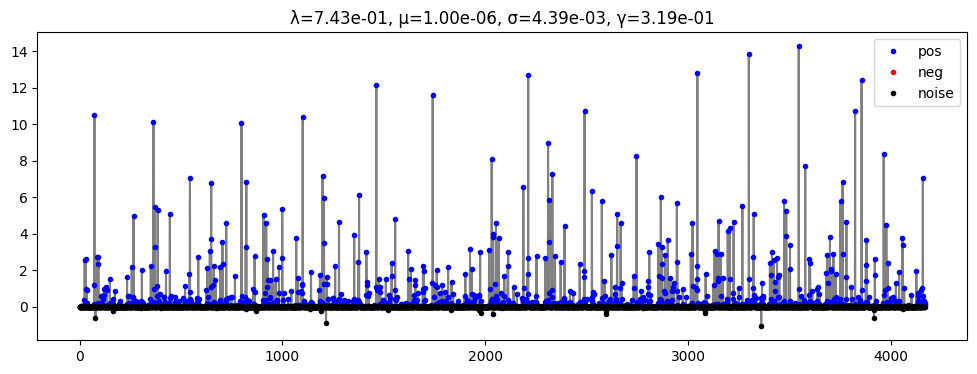

In [18]:
ret = run_em(y_, β = 1e10, γ_init = 0.01, max_iter = 50, tol = 1e-6)
print(ret[:4])
print(f"# noise: {sum(ret[4]==0)}")
print(f"# pos:   {sum(ret[4]>0)}")
print(f"# neg:   {sum(ret[4]<0)}")
plot_data(*ret[:4], y_, *ret[4:])


In [19]:
mean((cdf_true-mean(cdf_true))**2)/var(cdf_true)

NameError: name 'cdf_true' is not defined

In [20]:
min(ys),max(ys)

NameError: name 'ys' is not defined

In [21]:
percentile(ys,arange(0,101,10))

NameError: name 'ys' is not defined

In [22]:
reload(fpt)

<module 'fisher_plumes_tools' from '/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py'>

In [23]:
cdf_fun0 = lambda x: fpt.alaplace_cdf(la_, mu_, x)
cdf_fun1 = lambda x: cdf(*ret[:4], x)

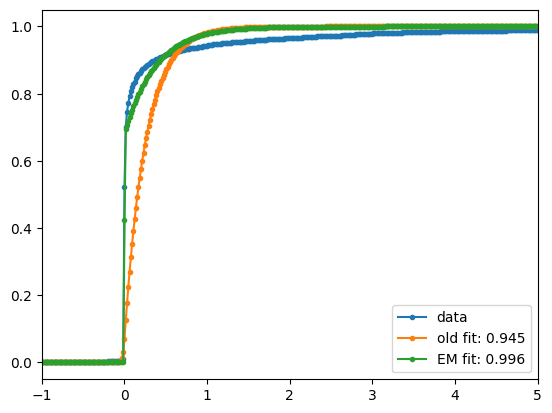

In [26]:
ys = array(sorted(y_))
#yl = percentile(ys, [0.1,99.9])
xv = linspace(ys[0], ys[-1], 1001)
#xv = ys
# cdf_true = arange(len(ys))/len(ys)
cdf_true = np.array([mean(ys<=x) for x in xv])
plot(xv, cdf_true, ".-",label="data" )
cdf0 = fpt.alaplace_cdf(la_, mu_, xv)
old_r2 = 1 - mean((cdf_true - cdf0)**2)/var(cdf_true)
old_r2 = fpt.compute_r2_value(cdf_fun0, ys, n = 1001)
plot(xv, cdf0, ".-", label=f"old fit: {old_r2:.3f}")
cdf1 = cdf(*ret[:4], xv)
new_r2 = 1 - mean((cdf_true - cdf1)**2)/var(cdf_true)
new_r2 = fpt.compute_r2_value(cdf_fun1, ys, n = 1001)
plot(xv, cdf1, ".-", label=f"EM fit: {new_r2:.3f}")
#plot(ys, 0*ys + mean(cdf_true), label="mean")
xlim(-1,5)
legend()